In [21]:
using ProgressMeter
using DifferentialEquations
using Printf
using Plots
gr(fmt="png")

include("../src/HHModel.jl")

Main.HHModel

# charging the RC circuit

$$ \frac{dV_{\text{c}}}{dt} = \frac{E - V_{\text{c}}}{RC}$$

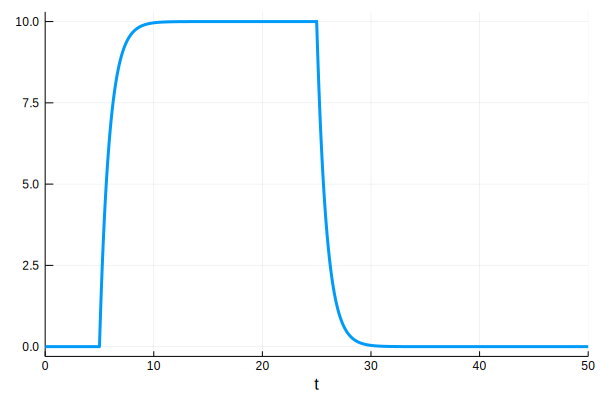

In [2]:
potential(t) = (5 < t < 25) ? 10 : 0
function RCCircuit(du, u, p, t)
    du[1] = (potential(t) - u[1]) / (p.R * p.C)
    u[2] = (potential(t) - u[1]) / p.R
end

u0 = [0.0, 0.0]
tspan = (0.0, 50.0)
prob = ODEProblem(RCCircuit, u0, tspan, (R=1, C=0.9))
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

fig_a = plot(sol, vars=(1), legend=nothing)

In [ ]:
_tspan = 0:0.01:50
_ans = hcat(sol(_tspan)...)
_vol = _ans[1, :]
_cur = _ans[2, :];

plot(_tspan, (potential.(_tspan) .- _vol) ./ 0.9, ylabel="\$\$\\mu A / cm^2\$\$")
#plot!(sol, vars=(2), legend=nothing)

# RCCircuit2

$$ \frac{dV_{\text{c}}}{dt} = \frac{E - V_{\text{c}}}{R_s C} - \frac{V_{\text{c}}}{R_m C}$$

In [45]:
voltage_step = (t, param) -> (param.start < t < param.start + param.duration) ? param.holding+param.step : param.holding
voltage_step_vec = (t, param) -> begin
    _ans = ones(size(t)) .* param.holding
    _ans[(param.start .< t) .& (t .< param.start + param.duration)] .= param.holding + param.step
    _ans
end

# type two in matlab -- transient

# biophysical model setup ==> usu. for maximum conductance
ikh = HHModel.high_voltage_gated_potassium(2.8, phi=0.85)
ikl = HHModel.low_voltage_gated_potassium(0.3, subtype=:kv1)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(13.0)
ih = HHModel.ihcurrent(0, level=1)
il = HHModel.leakage(0.01)

_model = [ikh, ikl, ina, ih, il];

In [32]:
ih_tail_step = (t, param) -> begin
    if param.start < t < param.start + param.duration
        return param.holding+param.step
    elseif t < param.start + param.duration + param.tail_duration
        return param.tail_holding
    else
        return param.holding
    end
end

ih_tail_step_vc = (t, param) -> begin
    _tmp = (x) -> ih_tail_step(x, param)
    _tmp.(t)
end

#27 (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


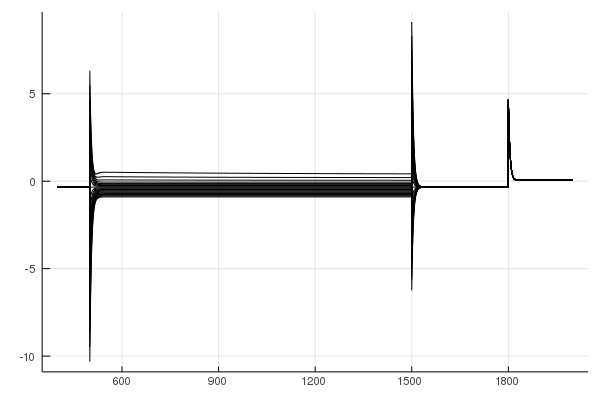

In [47]:
_v_holding = -70
u0 = HHModel.setup_init(_model, _v_holding)
_model_sim_vc = HHModel.VoltageClampSimulation(_model, ih_tail_step, C=0.9, Rs=6.0); # current clamp
tspan = (0.0, 2000.0)
_tspan = 400:0.01:2000
_v_steps = -90:5:10
pbar = Progress(length(_v_steps))
plot()
for _each_step in _v_steps
    param = (E=(sodium=82.0, potassium=-81.0, ih=-46.0, leak=-65.0, syn=3.0),
        stim=(holding=_v_holding, step=_each_step, start=500, duration=1000, tail_duration=300, tail_holding=-100)
    )

    prob = ODEProblem(_model_sim_vc, u0, tspan, param)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
    
    _vol = hcat(sol(_tspan)...)[1, :]
    _hol = ih_tail_step_vc(_tspan, param.stim)
    _cur = (_hol .- _vol) ./ (6.0)

    plot!(_tspan, _cur, color=:black)
    next!(pbar)
end
plot!(legend=nothing)

---
<img src="export/rc_2.jpeg" height="330" width="330"></img>

In [ ]:
# sweep
_sweep_protocol = [
    ("hdf5/gklv_0", 0),
    ("hdf5/gklv_0.15", 0.35),
    ("hdf5/gklv_0.3", 0.35),
    ("hdf5/gklv_0.45", 0.35),
    ("hdf5/gklv_0.6", 0.65),
    ("hdf5/gklv_0.75", 0.35),
    ("hdf5/gklv_1.1", 1.1),
]
for item in _sweep_protocol
    _export_name = item[1]
    ikl.g = item[2]
    # il.g = 0.03

    _v_holding = -70
    _v_steps = -5:5
    u0 = HHModel.setup_init(_model, _v_holding)
    tspan = (0.0, 1000.0)
    _tspan = 400:0.01:800

    _current = zeros((size(_tspan)[1], length(_v_steps)))
    _voltage = zeros(size(_current))
    _holding = zeros(size(_current))
    for (idx, step_size) = enumerate(_v_steps)
        param = (E=(sodium=82.0, potassium=-81.0, ih=-46.0, leak=-65.0, syn=3.0),
                 stim=(holding=_v_holding, step=step_size, start=500, duration=100))
        prob = ODEProblem(_model_sim_vc, u0, tspan, param)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

        _vol = hcat(sol(_tspan)...)[1, :]
        _hol = voltage_step_vec(_tspan, param.stim)
        _cur = (_hol .- _vol) ./ (6.0)

        _current[:, idx] = _cur
        _voltage[:, idx] = _vol
        _holding[:, idx] = _hol
    end

    # export as atf file
    # HHModel.export_as_atf(_export_name, _tspan, _current, _holding)
    HHModel.export_as_hdf5(_export_name, _tspan, _current, _holding)
end

# fig_a = plot(_tspan, _current, ylabel="\$\$\\mu A / cm^2\$\$", legend=nothing, color=:black)
# fig_b = plot(_tspan, _holding, ylabel="\$\$mV\$\$", legend=nothing, color=:black)
# fig_c = plot(_tspan, _voltage, ylabel="\$\$mV\$\$", legend=nothing, color=:black)
# plot(fig_a, fig_b, fig_c, layout=@layout([fig_a;fig_b;fig_c]))

In [ ]:
# ARCHIVED
ltk = HHModel.low_voltage_gated_potassium(0, subtype=:kv1);
ih = HHModel.ihcurrent(0);
il = HHModel.leakage(0.3)

voltage_step = (t, param) -> (param.start < t < param.start + param.duration) ? param.holding+param.step : param.holding
voltage_step_vec = (t, param) -> begin
    _ans = ones(size(t)) .* param.holding
    _ans[(param.start .< t) .& (t .< param.start + param.duration)] .= param.holding + param.step
    _ans
end
function RCCircuit2(du, u, p, t)
    _current_ih, _dih = HHModel.step(ih, V=u[1], var=u[2:2], E=-26)
    _current_ltk, _dltk = HHModel.step(ltk, V=u[1], var=u[3:4], E=-81)
    _current_il, _ = HHModel.step(il, V=u[1], var=Int[], E=-65)
    
    du[1] = (voltage_step(t, p.stim) - u[1]) / (p.Rs * p.C) - (_current_ltk+_current_ih+_current_il) / p.C
    du[2] = _dih[end]
    du[3:4] = _dltk
end

u0 = HHModel.setup_init([ih, ltk], -26)
tspan = (0.0, 150.0)
param = (Rs=1, # kΩ / cm^2
    C=0.9, # μA / cm^2
    stim=(holding=-26.0, step=3, start=50, duration=50)
)
prob = ODEProblem(RCCircuit2, u0, tspan, param)
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6);

_tspan = 0:0.01:150
_ans = hcat(sol(_tspan)...)
_vol = _ans[1, :]
_du_ltk = _ans[3:4, :]

plot(_tspan, (voltage_step_vec(_tspan, param.stim) .- _vol) ./ (param.Rs), label="\$\$\\mu A / cm^2\$\$")